In [1]:
#Preparing to get data from Kaggle
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
#Retrieving data from Kaggle
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign --force

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 611M/612M [00:21<00:00, 33.2MB/s]
100% 612M/612M [00:21<00:00, 29.9MB/s]


In [3]:
#Unpackaging zip file
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#This function unpacks pickle files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
#Data Preprocessing
import pandas as pd
import pickle
from PIL import Image
import numpy as np
images = []
images2 = []

#Gathering the image data in order to open and crop images down from train dataset.
df = pd.read_csv('Train.csv')
train_data = df['Path'].to_list()
RoiX1 = df['Roi.X1'].to_list()
RoiY1 = df['Roi.Y1'].to_list()
RoiX2 = df['Roi.X2'].to_list()
RoiY2 = df['Roi.Y2'].to_list()

'''
Opening the image and cropping so the sign is centered and takes up most of the image.
Once cropping is done, we add the image to the images list.
'''

for i,feature in enumerate(train_data):
  img = Image.open(feature)
  img = img.crop((RoiX1[i], RoiY1[i], RoiX2[i], RoiY2[i]))
  img = np.array(img.resize((16,16)))
  images.append(img)

#Storing the images and labels in a pickle file
train_data = np.array(images) #Converting image list to Numpy array
train_labels = df['ClassId'].to_numpy() #Converting labels column in the Train.csv file into a Numpy array
train_dict = {'data': train_data, 'labels': train_labels} #Storing images and labels in a dictionary
pickle.dump(train_dict,open('/content/train_batch','wb'))


#Gathering the image data in order to open and crop images down from test dataset.
df = pd.read_csv('Test.csv')
test_data = df['Path'].to_list()
RoiX1 = df['Roi.X1'].to_list()
RoiY1 = df['Roi.Y1'].to_list()
RoiX2 = df['Roi.X2'].to_list()
RoiY2 = df['Roi.Y2'].to_list()

'''
Opening the image and cropping so the sign is centered and takes up most of the image.
Once cropping is done, we add the image to the images list.
'''

for i,feature in enumerate(test_data):
  img = Image.open(feature)
  img = img.crop((RoiX1[i], RoiY1[i], RoiX2[i], RoiY2[i]))
  img = np.array(img.resize((16,16)))
  images2.append(img)

#Storing the images and labels in a pickle file
test_data = np.array(images2) # Converting image list to Numpy array
test_labels = df['ClassId'].to_numpy() #Converting labels column in Test.csv file into a Numpy array
test_dict = {'data': test_data, 'labels': test_labels} #Storing images and labels in a dictionary
pickle.dump(test_dict,open('/content/test_batch','wb'))



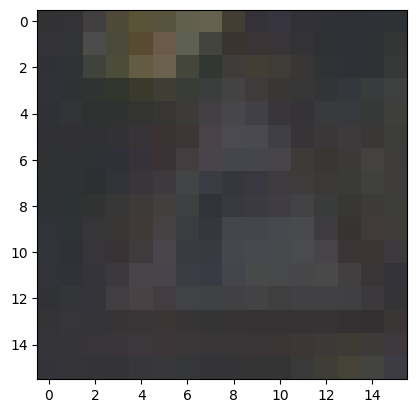

20


In [7]:
#Checking to see if images are cropped correctly and if label matches image.
import matplotlib.pyplot as plt
plt.imshow(train_data[0])
plt.show()
print(train_labels[0])

In [8]:
#Creating custom GTSRB dataset
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.nn.functional as F
class MyGTSRB(Dataset):
  def __init__(self, filename):
    #Unpacking pickle file
    dict_data = unpickle(filename)
    self.data = dict_data['data']
    self.labels = dict_data['labels']

    #Converting data and labels into torch tensors
    self.data = torch.tensor(self.data, dtype=torch.float32)
    self.labels = torch.tensor(self.labels, dtype=torch.long)
  def __len__(self): #Returns length of data
    return len(self.data)

  def __getitem__(self, idx): #Returns data and label at a given index
    return self.data[idx], self.labels[idx]

In [9]:
#Importing test and train data into datasets
train_dataset = MyGTSRB('train_batch')
test_dataset = MyGTSRB('test_batch')

In [10]:
#Importing datasets into a dataloader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=43, shuffle=False)

for x, y in test_dataloader:
    print(f"Shape of x [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [N, C, H, W]: torch.Size([43, 16, 16, 3])
Shape of y: torch.Size([43]) torch.int64


In [11]:
import torch.nn as nn

#Check if a CUDA-enabled GPU is available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

#Define a Multi-Layer Perceptron (MLP) class that inherits from nn.Module
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    #Defining the layers of the MLP as a sequential model
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(16*16*3, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 43)
    )
  def forward(self, x):
    return self.layers(x)

model = MLP().to(device)
print(model)

Using cpu device
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=43, bias=True)
  )
)


In [12]:
#Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train(data_loader, model, criterion, optimizer):
  model.train()
  num_batches = len(data_loader)
  num_items = len(data_loader.dataset)
  total_loss = 0
  total_correct = 0
  for data, target in data_loader:
    #Copy data and tragets to GPU
    data, target = data.to(device), target.to(device)

    #Do a forward pass
    output = model(data)

    #Calculate Loss
    loss = criterion(output, target)
    total_loss += loss

    #Count number of correct digits
    total_correct += (torch.argmax(output, dim=1) == target).sum().item()

    #Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  #Printing the average loss and accuarcy for train data
  train_loss = total_loss / num_batches
  train_accuracy = total_correct / num_items
  train_losses.append(train_loss.item())
  print(f"Train average loss: {train_loss:7f}, train accuracy: {train_accuracy:.2%}")
  #Printing the average loss and accuuracy for test data
  num_batches_test = len(test_dataloader)
  num_items_test = len(test_dataloader.dataset)
  total_loss_test = 0
  total_correct_test = 0
  for data, target in test_dataloader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    total_loss_test += loss
    total_correct_test += (torch.argmax(output, dim=1) == target).sum().item()
  test_loss = total_loss_test / num_batches_test
  test_accuracy = total_correct_test / num_items_test
  test_losses.append(test_loss.item())
  print(f"Test Average loss: {test_loss:7f}, test accuracy: {test_accuracy:.2%}")


Training epoch 1
-------------------------------
Train average loss: 2.772208, train accuracy: 46.18%
Test Average loss: 1.169647, test accuracy: 70.13%
Training epoch 2
-------------------------------
Train average loss: 0.934135, train accuracy: 74.12%
Test Average loss: 0.997127, test accuracy: 78.85%
Training epoch 3
-------------------------------
Train average loss: 0.706078, train accuracy: 81.20%
Test Average loss: 1.064657, test accuracy: 79.46%
Training epoch 4
-------------------------------
Train average loss: 0.633509, train accuracy: 83.21%
Test Average loss: 1.221195, test accuracy: 74.69%
Training epoch 5
-------------------------------
Train average loss: 0.607833, train accuracy: 84.05%
Test Average loss: 0.970437, test accuracy: 80.83%
Training epoch 6
-------------------------------
Train average loss: 0.511698, train accuracy: 86.54%
Test Average loss: 1.045625, test accuracy: 79.87%
Training epoch 7
-------------------------------
Train average loss: 0.467012, tra

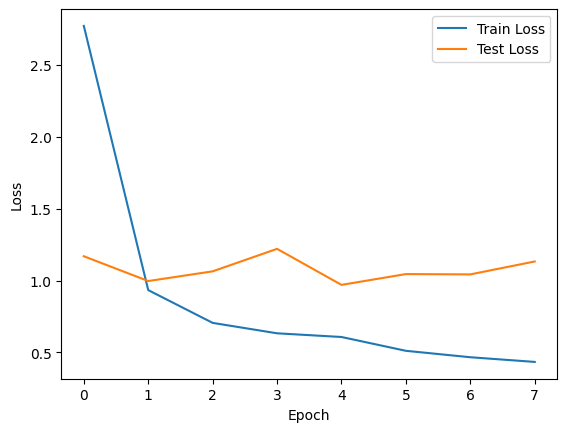

CPU times: user 1min 4s, sys: 469 ms, total: 1min 4s
Wall time: 1min 5s


In [14]:
#Training the model
%%time
epochs = 8
test_losses =[]
train_losses=[]
for epoch in range(epochs):
  print(f"Training epoch {epoch+1}\n-------------------------------")
  train(train_dataloader, model, criterion, optimizer)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Train accuracy = 88.92%, test accuaracy = 78.25%

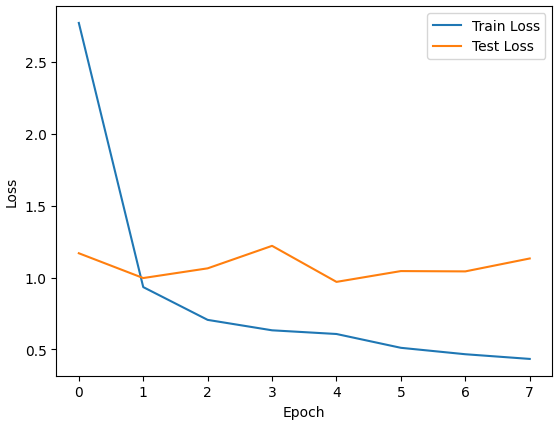